///---
layout: post
title: "Lights Out 퍼즐 풀기"
comments: true
share: true
date: 2019-04-21 14:13:00
description: 주어진 초기 상태에서, 모든 버튼의 불을 꺼지도록 하기 위해 눌러야 하는 버튼의 시퀀스를 찾아본다.
tags: python math
sitemap :
    changefreq : daily
    priority : 1.0
///---

# Lights Out 퍼즐 풀기

## Lights Out 퍼즐 설명
아래 그림과 같이 일부 버튼은 불이 켜져 있고 다른 일부는 꺼져 있다. 버튼을 누르면 그 버튼의 현재 상태가 반대로 바뀌고 동시에 눌러진 버튼 주변 4개 버튼의 상태도 반대로 바뀐다. 이 퍼즐의 목적은 버튼을 눌러서 모든 버튼의 불을 꺼지게 하는 것이다.

In [16]:
# 설명 그림 Plot 용 코드
# Third party imports
from jupyterthemes import jtplot
from matplotlib.pyplot import subplots
from numpy import flipud
from numpy.core.numeric import array
from matplotlib.colors import ListedColormap

jtplot.style('monokai', fscale=1.3)

def draw_light_out_rule(light_before, light_after, push_pos):
    # cmap = 'CMRmap'
    cmap = ListedColormap(['k', 'g'])
    fig, ax = subplots(1, 3,
                       figsize=(10, 4),
                       gridspec_kw = {'width_ratios':[5, 1, 5]})

    ax[0].pcolor(flipud(light_before), cmap=cmap)
    ax[2].pcolor(flipud(light_after), cmap=cmap)

    ax[1].axis('off')
    ax[1].text(0.20, 0.4, f'Push\n{push_pos}\nbutton',
               color='w',
               ha="center",
               size=0.25 * fig.dpi,
               transform=ax[1].transAxes,
               bbox=dict(boxstyle='rarrow', fc="grey", ec="k"))
    
    ax[0].grid(True, color='grey', linewidth=3)
    ax[2].grid(True, color='grey', linewidth=3)
    
    ax[0].tick_params(labelleft=False,labelbottom= False)
    ax[2].tick_params(labelleft=False,labelbottom= False)


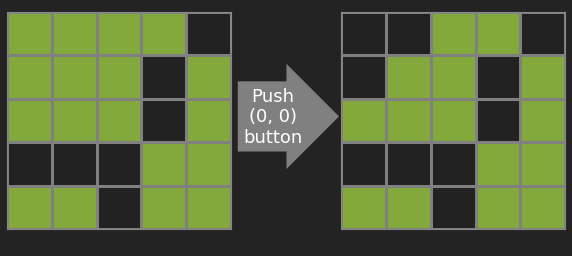

In [17]:
lights_before = array([[1, 1, 1, 1, 0],
                       [1, 1, 1, 0, 1],
                       [1, 1, 1, 0, 1],
                       [0, 0, 0, 1, 1],
                       [1, 1, 0, 1, 1]])

lights_after = array([[0, 0, 1, 1, 0],
                      [0, 1, 1, 0, 1],
                      [1, 1, 1, 0, 1],
                      [0, 0, 0, 1, 1],
                      [1, 1, 0, 1, 1]])

draw_light_out_rule(lights_before, lights_after, '(0, 0)')

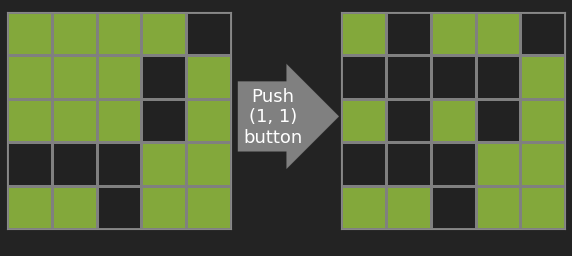

In [18]:
lights_before = array([[1, 1, 1, 1, 0],
                       [1, 1, 1, 0, 1],
                       [1, 1, 1, 0, 1],
                       [0, 0, 0, 1, 1],
                       [1, 1, 0, 1, 1]])

lights_after = array([[1, 0, 1, 1, 0],
                      [0, 0, 0, 0, 1],
                      [1, 0, 1, 0, 1],
                      [0, 0, 0, 1, 1],
                      [1, 1, 0, 1, 1]])

draw_light_out_rule(lights_before, lights_after, '(1, 1)')

## 수학적 접근

### Galois Filed 2
GF(2)는 갈루아 필드(Galois Filed 2)를 간략하게 표현한 것이다.
갈루아 필드의 +, x는 아래와 같이 정의 된다.

In [19]:
from IPython.display import HTML

def multi_table(table_list):
    ''' Acceps a list of IpyTable objects and returns a table which contains each IpyTable in a cell
    '''
    return HTML(
        '<table>' + 
        ''.join(['<td>' + table.to_html(index=False) + '</td>' for table in table_list]) +
        '</table>'
    )

In [20]:
from numpy import zeros
from pandas import DataFrame
data_mul = zeros((2,), dtype=[('x', 'i4'), ('0', 'i4'), ('1', 'i4')])
data_mul[:] = [(0, 0, 0), (1, 0, 1)]
df_mul = DataFrame(data_mul)

data_add = zeros((2,), dtype=[('+', 'i4'), ('0', 'i4'), ('1', 'i4')])
data_add[:] = [(0, 0, 1), (1, 1, 1)]
df_add = DataFrame(data_add)
multi_table([df_mul, df_add])

x,0,1
0,0,0
1,0,1
+,0,1
0,0,1
1,1,1


갈루아 필드의 특성은 다음과 같다.

- 덧셈은 modulo 2 이며, 이것은 배타적 논리합과 같다.
- 뺄셈은 덧셈과 동일하다. 1의 음수는 1이고, 0의 음수는 0이다.
- 곱셈은 일반적인 0, 1의 곱셈과 같다.

### Lights Out 퍼즐을 갈루아 필드로 표현

Lights Out 의 불이 켜진 상태를 1, 꺼진 상태를 0으로 놓는다. 그리고 버튼이 눌려서 상태가 변하는 것을 갈루아 필드의 +1로 생각해 보자.
  
```
켜진 상태(1) + 1 = 꺼진 상태(0)
꺼진 상태(0) + 1 = 켜진 상태(1)
```
위의 수식은 버튼이 눌렸을 때의 변화를 GF(2)의 덧셈으로 표현 가능함을 보여준다.

Light Out 문제는 GF(2)에 포함된 벡터의 덧셈 문제로 변환 될 수 있다.
문제를 간단하게 하기 위해 버튼을 2x2로 제한하면 상태 변화 벡터($v_i$)는 아래와 같이 정의 된다.

<table><td><table border="1" class="dataframe">
  <caption>v<sub>1</sub></caption>
  <thead>
    <tr style="text-align: right;">
      <th>1</th>
      <th>1</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>1</td>
      <td>0</td>
    </tr>
  </tbody>
</table></td><td><table border="1" class="dataframe">
 <caption>v<sub>2</sub></caption>
  <thead>
    <tr style="text-align: right;">
      <th>1</th>
      <th>0</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>1</td>
      <td>1</td>
    </tr>
  </tbody>
</table></td><td><table border="1" class="dataframe">
 <caption>v<sub>3</sub></caption>
  <thead>
    <tr style="text-align: right;">
      <th>1</th>
      <th>1</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>0</td>
      <td>1</td>
    </tr>
  </tbody>
</table></td><td><table border="1" class="dataframe">
 <caption>v<sub>4</sub></caption>
  <thead>
    <tr style="text-align: right;">
      <th>0</th>
      <th>1</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>1</td>
      <td>1</td>
    </tr>
  </tbody>
</table></td></table>



<br>  
초기 상태를 $s$로 놓고 $s$를 0으로 만드는 버튼은 다음과 같이 표현 할 수 있다.

$$s + v_i + v_j + v_k \cdots = 0,\quad \quad \quad i\neq j\neq k\quad(v_1 + v_1 = 0\text{이므로})$$

즉 Lights Out 문제는 GF(2)에서 $s$가 $v_i$의 벡터의 부분 집합으로 표현 할수 있는가의 문제가 된다.

## 해법을 찾는 효과적인 방안

작성중

## 참고자료
[1] 필립 클라인. (2019). 3. 벡터. Coding The Matrix (90)  